# Fourier Feature Mapping on PytorchLightening

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

from turboflow.dataloaders import FFMDataModule
from turboflow.models import FFN

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Input data

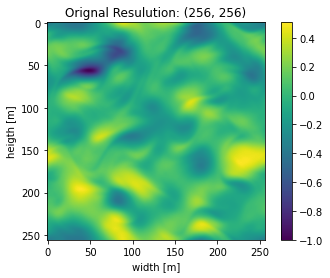

Image output parameter: 1 -> pixel intensity


In [3]:
## SET UP DATA
img_dir = '../data/DNS_Scal/'
img_name = 'Scalar_36'
img_path = img_dir + img_name
img = np.loadtxt(open(img_path, "rb"), delimiter="\t")
img = img[:,3].reshape((256,256))

# normalization
img = img / np.max(np.abs(img))

ntarget = 1
prediction = 'pixel intensity'

plt.title('Orignal Resulution: (%d, %d)' % img.shape)
plt.imshow(img)
plt.xlabel('width [m]')
plt.ylabel('heigth [m]')
plt.colorbar()
plt.show()
print('Image output parameter:', ntarget, '->', prediction)

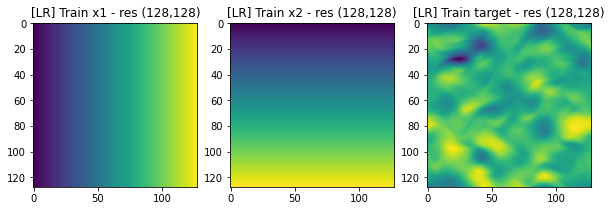

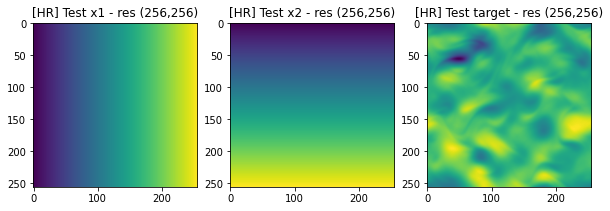

In [4]:
# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img] # full size [coords, img]

ds = 2
train_data = [x_test[::ds,::ds,:], img[::ds,::ds]] # downsampled resultion (one every 2)


plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('[LR] Train x1 - res (%d,%d)' % train_data[0][:,:,0].shape)
plt.imshow(train_data[0][:,:,0])
plt.subplot(132)
plt.title('[LR] Train x2 - res (%d,%d)' % train_data[0][:,:,1].shape)
plt.imshow(train_data[0][:,:,1])
plt.subplot(133)
plt.title('[LR] Train target - res (%d,%d)' % train_data[1].shape)
plt.imshow(train_data[1])
plt.show()

plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('[HR] Test x1 - res (%d,%d)' % test_data[0][:,:,0].shape)
plt.imshow(test_data[0][:,:,0])
plt.subplot(132)
plt.title('[HR] Test x2 - res (%d,%d)' % test_data[0][:,:,1].shape)
plt.imshow(test_data[0][:,:,1])
plt.subplot(133)
plt.title('[HR] Test target - res (%d,%d)' % test_data[1].shape)
plt.imshow(test_data[1])
plt.show()

## Hyper params and dataset init

In [5]:
img_size = img.shape[0]
mapping_nfeatures = 256
training_downsampling_factor = 2
testing_upsampling_factor = 2

In [6]:
mapping_dict = {}
mapping_dict['None'] = None
mapping_dict['Basic'] = {'nfeatures': 2, 'scale': 1}
mapping_dict['Gauss1'] = {'nfeatures': mapping_nfeatures, 'scale': 1}
mapping_dict['Gauss10'] = {'nfeatures': mapping_nfeatures, 'scale': 10.}
mapping_dict['Gauss100'] = {'nfeatures': mapping_nfeatures, 'scale': 100.}

# compute the fouirier basis a priori
def random_fourier_freqs(scale, nfeatures):
    return scale*np.random.normal(0, 1, (nfeatures, 2))

# initialize the data module
dm_dict = {}
for key in mapping_dict:
    mapping = mapping_dict[key]
    if 'Basic' in key:
        mapping['B'] = np.eye(2)
    if 'Gauss' in key:
        mapping['B'] = random_fourier_freqs(mapping['scale'], mapping['nfeatures'])
    dm_dict[key] = FFMDataModule(img, batch_size=1, training_downsampling_factor=2)
print('success')

print(dm_dict)

success
{'None': <turboflow.dataloaders.FFMDataModule object at 0x7f304d24a8e0>, 'Basic': <turboflow.dataloaders.FFMDataModule object at 0x7f304d24aa00>, 'Gauss1': <turboflow.dataloaders.FFMDataModule object at 0x7f31418a0ca0>, 'Gauss10': <turboflow.dataloaders.FFMDataModule object at 0x7f304d24afa0>, 'Gauss100': <turboflow.dataloaders.FFMDataModule object at 0x7f304d26f070>}


# Model and Training code

In [ ]:
experiments = ['None', 'Basic', 'Gauss1', 'Gauss10', 'Gauss100']
layers = [256, 256, 256, ntarget]

for experiment in experiments:

    dm = dm_dict[experiment]
    mapping = mapping_dict[experiment]

    model = FFN(layers, mapping, device)
    print(model)
    model.to(device)


    max_iters = 2000
    trainer = pl.Trainer(gpus=1, 
                         check_val_every_n_epoch=200, 
                         max_epochs=max_iters, 
                         callbacks=[EarlyStopping(monitor='valid_loss')])
    trainer.fit(model, dm)

    model.eval().to(device)

    sizes = [32, 64, 128, 256, 512]
    fig, axs = plt.subplots(1, len(sizes), figsize=(20,10))
    for s, size in enumerate(sizes):
        coords = np.linspace(0, 1, size, endpoint=False)
        coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
        x = torch.from_numpy(coords).float() #XY x 2 (x,y)
        x = x.to(device)
        pred = model(x)
        print(pred.shape)

        axs[s].imshow(pred.cpu().detach().numpy().squeeze())
        axs[s].set_title('Res %dx%d' % (size, size))
    plt.show()

In [ ]:
# class MyFourierLayer(torch.nn.Module):
#     """
#     Custom Fourier Layer that minim the one proposed by 
#     On the eigenvector bias of Fourier feature networks: From regressionto solving multi-scale PDEs with physics-informed neural networks
#     S.  Wang,  H.  Wang  and  P.  Perdikaris, 2021 
#     https://doi.org/10.1016/j.cma.2021.113938
#     """
#     def __init__(self, B):
#         super().__init__()
        
#         self.freqs = B
#         self.size_in, self.size_out = self.freqs.shape
        
#         weights = torch.Tensor(size_out, size_in)
#         self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.

#         # initialize weights and biases
#         nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        

#     def forward(self, x):
#         # x in D
#         # B in MxD
#         # W in 1x2m
#         freqs_times_x = torch.matmul(x, self.freqs.t())
#         sin_cos = torch.cat([torch.cos(X), torch.sin(X)], axis=-1)
#         w_times_x = torch.mm(x, self.weights.t())
#         torch.mm(self.weight)
#         return torch.add(w_times_x, self.bias)  # w times x + b
    

    
# x, y, d = 64, 64, 2
# m = 128

# B = torch.normal(0, np.sqrt(1), size=(m, d))


# W = torch.randn((1, 2*m))
# X = torch.randn((x,y,d))

# print(B.shape)
# print(X.shape)
# print(W.shape)

# X = torch.matmul(X, B.t())
# print(X.shape)
# X = torch.cat([torch.cos(X), torch.sin(X)], axis=-1)
# print(X.shape)
# X = torch.mul(X, W.t())
# print(X.shape)


# FL = MyFourierLayer()
# x = torch.randn(())

In [7]:
mapping_dict = {}
mapping_dict['Gauss1'] = {'nfeatures': mapping_nfeatures, 'scale': 1}
mapping_dict['Gauss10'] = {'nfeatures': mapping_nfeatures, 'scale': 10.}
mapping_dict['Gauss30'] = {'nfeatures': mapping_nfeatures, 'scale': 30.}

# compute the fouirier basis a priori
def random_fourier_freqs(scale, nfeatures):
    return scale*np.random.normal(0, 1, (nfeatures, 2))

# initialize the data module
dm_dict = {}
for key in mapping_dict:
    mapping = mapping_dict[key]
    if 'Gauss' in key:
        mapping['B'] = random_fourier_freqs(mapping['scale'], mapping['nfeatures'])

dm = FFMDataModule(img, batch_size=1, training_downsampling_factor=2)
print(dm)
print('success')

success


In [8]:
from turboflow.models import FFN_Improved

layers = [256, 256, 256, 1]

model = FFN_Improved(layers,
                     mapping_dict['Gauss1'], 
                     mapping_dict['Gauss10'],
                     mapping_dict['Gauss30'], device)
print(model)
model.to(device)

FFN_Improved(
  (mlp): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1536, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Tanh()
  )
)


FFN_Improved(
  (mlp): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1536, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Tanh()
  )
)

In [20]:
max_iters = 10000
trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[EarlyStopping(monitor='valid_loss')])
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 525 K 
------------------------------------
525 K     Trainable params
0         Non-trainable params
525 K     Total params
2.101     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

torch.Size([64, 64, 1])
torch.Size([128, 128, 1])
torch.Size([256, 256, 1])
torch.Size([512, 512, 1])
torch.Size([768, 768, 1])


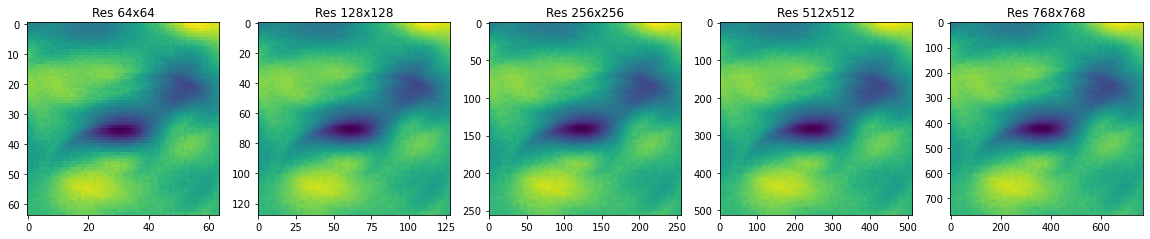

In [23]:
model.eval().to(device)

sizes = [64, 128, 256, 512, 512+256]
fig, axs = plt.subplots(1, len(sizes), figsize=(20,10))
for s, size in enumerate(sizes):
    coords = np.linspace(0, 0.4, size, endpoint=False)
    coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
    x = torch.from_numpy(coords).float() #XY x 2 (x,y)
    x = x.to(device)
    pred = model(x)
    print(pred.shape)

    axs[s].imshow(pred.cpu().detach().numpy().squeeze())
    axs[s].set_title('Res %dx%d' % (size, size))
plt.show()